In [50]:
# Agregamos la ruta actual como parte de las carpetas donde python busca los módulos que estamos importando (En este caso para importar el módulo de las constantes)
import sys
sys.path.append('./')

In [51]:
# Importamos librerías necesarias
import requests # Descarga
import gzip # Descompresión de los archivos
import io # Uso de memoria temporal
import os # Funciones del sistema
import pandas as pd # Necesario para lectura de archivos
import json # Trabajar con archivos json
from tqdm import tqdm # Barra de progreso
from sklearn.preprocessing import OneHotEncoder # Codificador
import matplotlib.pyplot as plt # Gráficas
from collections import Counter, defaultdict # Tools
import numpy as np # Trabajo con arrays
from nltk import ngrams #N-gramas
from nltk.probability import FreqDist # Frecuencia de N-gramas
from constants import DATASETS_URL, DATASETS_FOLDER_PATH, MUESTRA_DS_PATH, DATASETS_PATH # Constantes

# Descarga de los datos

In [52]:
#Creo un bucle que realice la descarga de cada archivo .gz y guarde solamente el .jsonl
def download_datasets(urls, output_folder_path):
    
    """
    Función para descargar los datasets
    Args:
        urls(list) = Recibe una lista de urls
        output_folder_path(string) = Ruta de la carpeta donde se almacenaran los datasets
    Returns:
        None
    """
    
    #Creo la carpeta de destino si no existe
    os.makedirs(output_folder_path, exist_ok=True)
    
    for url in urls:
        #Obtengo el nombre del dataset
        name = url.split('/')[-1][:-3]

        #Concatenamos la ruta de destino con el nombre del archivo
        dataset_path = os.path.join(output_folder_path, name)
    
        #En caso de que ya tenga descargado alguno de los datasets lo salto
        if os.path.exists(dataset_path):
            continue
        
        #Realizo la descarga
        res = requests.get(url)
        
        #Verificamos la conexión
        if not res.ok:
            raise Exception('Ha ocurrido un error en la petición')
        
        #Cargo el archivo en memoria 
        temp_file = io.BytesIO(res.content)
        
        #Abro el archivo .gz para extraer el archivo .jsonl
        with gzip.open(temp_file, 'rt', encoding='utf-8') as tf:
            
            #Creo el archivo .jsonl y escribo los datos
            with open(dataset_path, 'w', encoding='utf-8') as f:
                f.write(tf.read())
        
        print(f"Archivo guardado en: {os.path.abspath(dataset_path)}")


In [53]:
# Verificamos si ya están descargados, en caso de que alguno lo esté, lo saltamos
if not all(os.path.exists(dataset) for dataset in DATASETS_PATH):
    download_datasets(DATASETS_URL, DATASETS_FOLDER_PATH)

# Análisis exploratorio de los datos

In [54]:
# Creamos una función para realizar el conteo de cuantas reviews hay en el dataset por estrellas
def contar_reviews_por_estrellas(dataset_path):
    """
    Esta función cuenta cuantas reviews tenemos por cada valoración
    Args:
        dataset_path (string): Ruta del dataset
        dataset_name (string): Nombre de dataset
    Returns:
        (dict, int): Devuelve una tupla que contiene como primer elemento un diccionario que tiene como llave la valoración y como valor el número de reviews con esa valoración y segundo elemento de la tupla es el total de registros en el dataset
    """
    # Creamos un diccionario para almacenar el conteo de reviews
    conteo = defaultdict(int)
    
    print('Contando y analizando reviews...')
    
    # Abrimos el archivo
    with open(dataset_path, 'r', encoding='utf8') as f:
        
        # Contamos cuantas lineas tenemos
        num_lines = 0
        
        # Regresamos el puntero al inicio
        f.seek(0)
        
        #Iteramos sobre cada linea
        for line in f:
            # Sumamos una línea
            num_lines += 1
            
            # Sumamos cada review
            try:
                data = json.loads(line)
                rating = data.get('rating')
                if rating is not None:
                    conteo[rating] += 1
            except json.JSONDecodeError:
                continue
        return conteo, num_lines
            

## Para realizar el proyecto voy a dividir las reviews en 3 grupos:
* **Bueno** : 4-5 Estrellas
* **Neutral** : 3 Estrellas
* **Malo** : 1-2 Estrellas


In [55]:
# Creamos una función para realizar un muestreo balanceado
def muestreo_balanceado(datasets, output_path, muestras_por_categoria):
    """
        Esta función realiza un muestreo en diferentes datasets de manera balanceada usando un enfoque probabilístico para evitar de tener sesgos en nuestra información y que sea lo más representativa posible
    Args:
        datasets (list): Ruta de los datasets a muestrear
        output_path (string): Ruta del archivo donde se almacenarán los datos tomados
        muestras_por_categoria (int): Número de muestras finales por cada categoría
    Returns:
        None
    """
    # Dividimos el número de muestras finales por cuantos datasets se van a muestrear, para así tener información balanceada
    samples = int(muestras_por_categoria / len(datasets))

    # Diccionarios con cada categoría
    categories = {
        1: "Malo", 
        2: "Malo", 
        3: "Neutral", 
        4: "Bueno", 
        5: "Bueno"
    }

    # Abrimos en modo escritura el archivo final
    with open(output_path, "w", encoding="utf8") as f:
        
        # Mediante un bucle iteramos sobre cada dataset
        for dataset in datasets:

            # Tomamos el nombre
            ds_name = dataset.split("/")[-1][:-6]

            print("Empezando muestreo balanceado en", ds_name)

            #Haciendo uso de la función contar_reviews_por_estrellas tomamos la distribución del dataset y su longitud
            conteo, num_lines = contar_reviews_por_estrellas(dataset)

            print("Distribución por estrellas: ", dict(conteo))

            # Dividimos el número de muestras en 2, y mitad para 1 y 2 para categoría malo, y mitad de 4 y 5 para la categoría bueno y en neutral lo dejamos igual
            muestras_a_tomar = {
                1: samples // 2,  # Mitad para "Malo"
                2: samples // 2,  # Mitad para "Malo"
                3: samples,       # Todas las de "Neutral"
                4: samples // 2,  # Mitad para "Bueno"
                5: samples // 2   # Mitad para "Bueno"
            }

            print("Muestras a tomar: ", muestras_a_tomar)
            
            # Abrimos en modo lectura el dataset
            with open(dataset, "r", encoding="utf8") as ds:
                
                #Iteramos sobre cada linea el dataset
                for line in tqdm(ds, total=num_lines, desc=f"Muestreando {ds_name}"):
                    
                    try:
                        # Cargamos como json cada línea
                        data = json.loads(line)
                        # Obtenemos la valoración
                        rating = data.get("rating")

                        # En caso de que la valoración NO sea de tipo int (o Nula) la saltamos
                        if rating is None or rating not in muestras_a_tomar:
                            continue
                        
                        # Si aun debemos tomar muestras de esa catearía actualizamos la probabilidad de tomar esa muestra
                        if muestras_a_tomar.get(rating, 0) > 0:
                            prob = muestras_a_tomar[rating] / conteo[rating]

                        # Tomamos un número random entre 0 a 1, y si la probabilidad de tomar esa linea es mayor, la tomamos
                        if np.random.random() < prob:
                            text = data.get('text')
                            
                            # Desde aquí vamos a categorizar cada registro
                            output_line = {
                                "category": categories[rating],  
                                "text": text
                            }
                            
                            #Lo parseamos de un obejto tipo python a tipo JSON
                            json_line = json.dumps(output_line)
                            
                            #Escribimos el registro en el archivo final
                            f.write(
                                f'{json_line}\n'
                            )
                            # Actualizamos los números para no sesgar las futuras probabilidades
                            muestras_a_tomar[rating] -= 1
                            conteo[rating] -= 1

                        # En caso de que ya hayamos terminado de tomar todas las reviews necesarias de ese dataset salimos del bucle
                        if all(x == 0 for x in muestras_a_tomar.values()):
                            break

                    except json.JSONDecodeError:
                        continue

In [56]:
# En caso de que ya exista omitimos este paso
if not os.path.exists(MUESTRA_DS_PATH):
    muestreo_balanceado(DATASETS_PATH, MUESTRA_DS_PATH, 100)

Empezando muestreo balanceado en Video_Games
Contando y analizando reviews...
Distribución por estrellas:  {4.0: 617251, 5.0: 2827881, 3.0: 340086, 1.0: 589519, 2.0: 249878}
Muestras a tomar:  {1: 16, 2: 16, 3: 33, 4: 16, 5: 16}


Muestreando Video_Games: 100%|██████████| 4624615/4624615 [00:15<00:00, 297358.62it/s]


Empezando muestreo balanceado en Electronics
Contando y analizando reviews...
Distribución por estrellas:  {3.0: 2883065, 1.0: 5358800, 5.0: 27829748, 4.0: 5557725, 2.0: 2257604, 0.0: 2}
Muestras a tomar:  {1: 16, 2: 16, 3: 33, 4: 16, 5: 16}


Muestreando Electronics: 100%|██████████| 43886944/43886944 [02:25<00:00, 301102.31it/s]


Empezando muestreo balanceado en Cell_Phones_and_Accessories
Contando y analizando reviews...
Distribución por estrellas:  {4.0: 2446330, 5.0: 12769358, 3.0: 1543387, 2.0: 1251658, 1.0: 2802212}
Muestras a tomar:  {1: 16, 2: 16, 3: 33, 4: 16, 5: 16}


Muestreando Cell_Phones_and_Accessories: 100%|██████████| 20812945/20812945 [01:07<00:00, 306314.72it/s]


In [57]:
# Leemos el archivo que hemos creado
df = pd.read_json(MUESTRA_DS_PATH, lines=True)

In [58]:
# Vamos a verificar si existe algún valor duplicado
df.duplicated().any()

False

In [59]:
# Eliminamos los duplicados
df.drop_duplicates(inplace=True)
print(f'Hay {df.duplicated().sum()} registros duplicados') if df.duplicated().any() else print('No hay registros duplicados')

No hay registros duplicados


In [60]:
# Eliminamos cualquier fila que contenga un valor nulo
df = df.dropna(subset=['text', 'category']).reset_index(drop=True)

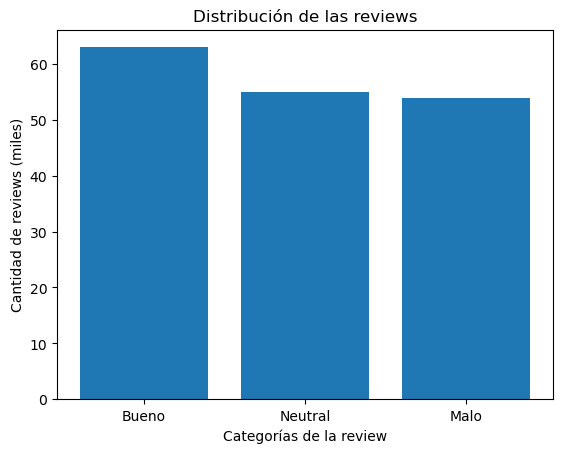

In [61]:
# Vamos a visualizar la distribución de las reviews
cat_count = df['category'].value_counts()

plt.bar(cat_count.index, cat_count.values)
plt.xlabel('Categorías de la review')
plt.ylabel('Cantidad de reviews (miles)')
plt.title('Distribución de las reviews')
plt.show()

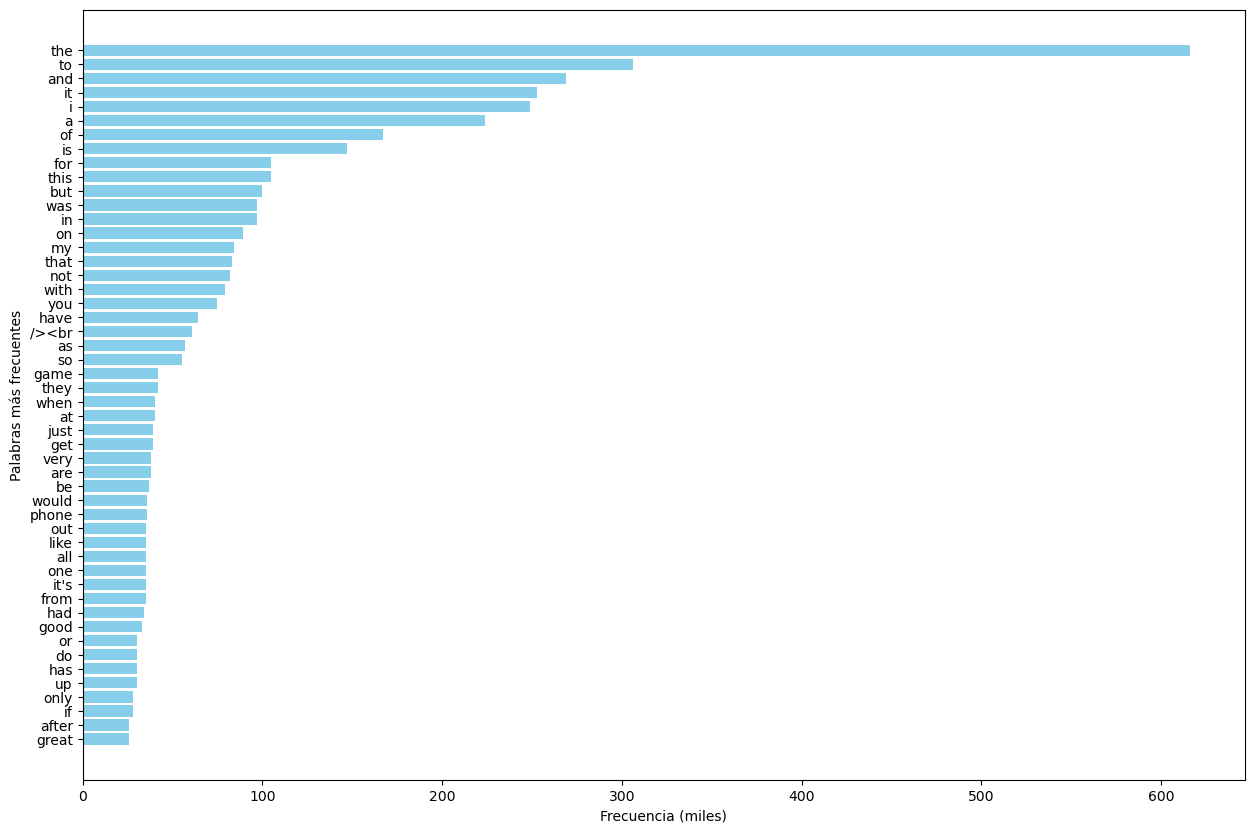

In [62]:
# Separamos cada review por palabras
splitted_reviews = df['text'].str.lower().str.split()

# Cada review spliteada la convertimos en una serie y la apilamos(es decir cada palabra)
words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)

# Contamos cuanto se repite cada palabra
word_count = Counter(words)

# Tomamos las 50 primeras
most_common_words = word_count.most_common(50)

# Las pasamos a un array
most_common_words = np.array(most_common_words)

# Ploteamos
plt.figure(figsize=(15, 10))
plt.barh(most_common_words[:, 0], most_common_words[:, 1].astype(int), color='skyblue')
plt.ylabel('Palabras más frecuentes')
plt.xlabel('Frecuencia (miles)')
plt.gca().invert_yaxis()
plt.show()

C:\Users\aleja\AppData\Local\Temp\ipykernel_28024\1450677769.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=45)
C:\Users\aleja\AppData\Local\Temp\ipykernel_28024\1450677769.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[1].set_xticklabels(axis[1].get_xticklabels(), rotation=60)


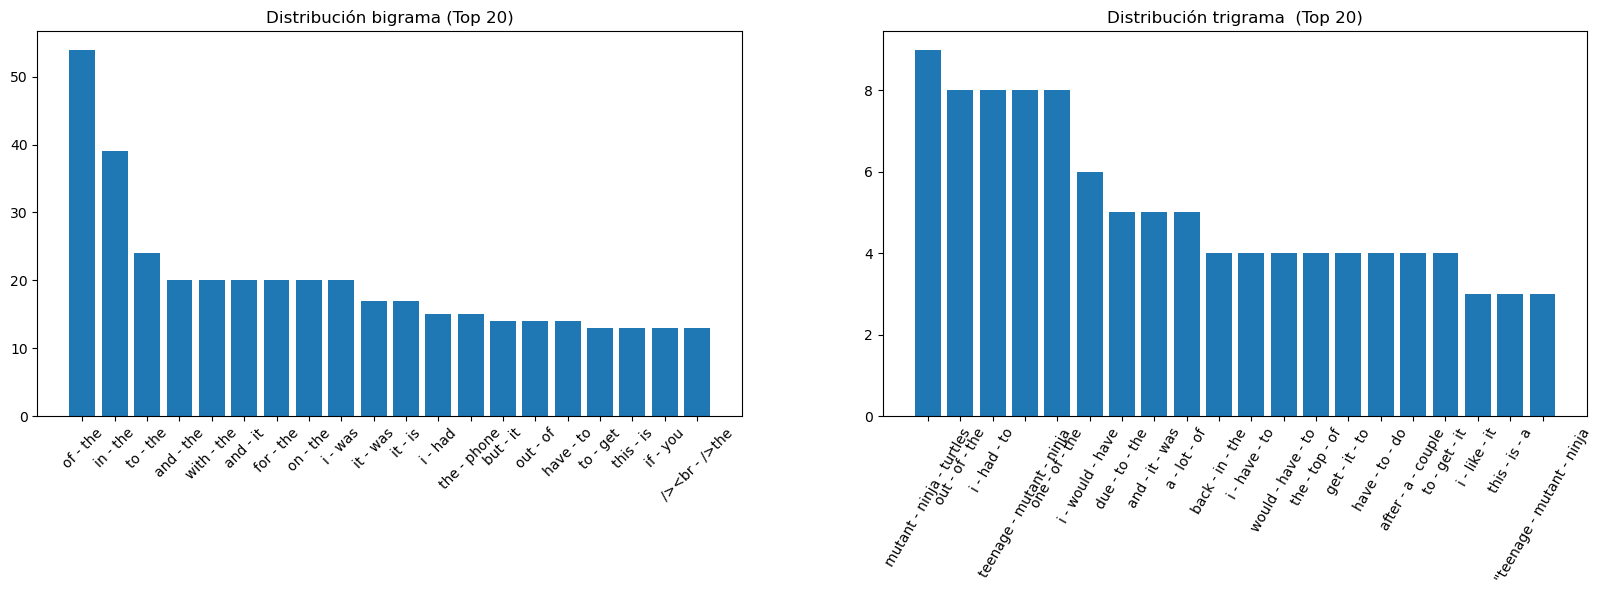

In [66]:
# Veamos la distribución de las palabras en bigramas y trigramas

# Tomamos las frecuencias
bigrams_freq = FreqDist(ngrams(words, 2))
trigrams_freq = FreqDist(ngrams(words, 3))

# Separamos por grupo de palabras y su frecuencia
bi_labels , bi_freq = zip(*bigrams_freq.most_common(20))
tri_labels , tri_freq = zip(*trigrams_freq.most_common(20))

# Creamos la figura y ploteamos
_ , axis= plt.subplots(1, 2, figsize=(20, 5))

axis[0].set_title('Distribución bigrama (Top 20)')
axis[0].bar([f'{bi_label[0]} - {bi_label[1]}' for bi_label in bi_labels], bi_freq)
axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=45)

axis[1].set_title('Distribución trigrama  (Top 20)')
axis[1].bar([f'{tri_label[0]} - {tri_label[1]} - {tri_label[2]}' for tri_label in tri_labels], tri_freq)
axis[1].set_xticklabels(axis[1].get_xticklabels(), rotation=60)
plt.show()


# Codificación los sentimientos a predecir

In [64]:
# Instancio el codificador OneHot para las clases
cat_encoder = OneHotEncoder(sparse_output=False)

# Creamos las columnas para las categorías
categories = cat_encoder.fit_transform(df[['category']])

# Transformamos el array a un dataframe de pandas
categories_df = pd.DataFrame(categories, columns=cat_encoder.categories_[0])

# Concatenamos el dataframe original con la columna del OneHot y dropeamos la columna de categorías
df = pd.concat([df, categories_df], axis=1).drop(columns='category')

# Veamos como quedo 
df.head()

,text,Bueno,Malo,Neutral
0,Kept my son occupied for just a short time. H...,0.0,0.0,1.0
1,We got this because my daughter loves to dance...,0.0,1.0,0.0
2,Buttons stick,0.0,0.0,1.0
3,"I would like to like this game, this type of g...",1.0,0.0,0.0
4,some games are hard to get out but it does wha...,0.0,0.0,1.0


In [65]:
# Guardamos el dataframe como un archivo csv para poder usarlo en los demás notebooks
codified_df_path = os.path.join(DATASETS_FOLDER_PATH, 'codified_path.csv')

if not os.path.exists(codified_df_path):
    df.to_csv(codified_df_path, index=False)